## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

import stateinterpreter.MD 
import stateinterpreter.plot

is_reload = False

if is_reload:
    from importlib import reload
    reload(stateinterpreter)
    reload(stateinterpreter.MD)
    reload(stateinterpreter.classifier)
    reload(stateinterpreter.plot)

## Loader

In [2]:
from stateinterpreter.MD import Loader

# Paths and filenames
folder = "../md_dataset/chignolin-unbiased/"
colvar_file = folder + 'COLVAR'

traj_dict = {
    'trajectory' : folder+'CLN025-0-protein-ALL.dcd',
    'topology' : folder+'CLN025-0-protein.pdb'
}

# Compute descriptors from traj
data = Loader(colvar_file, kbt=2.827, stride=20)
# Rename TICA CVs
data.colvar = data.colvar.rename(columns={'deep.node-4': 'tica1','deep.node-3': 'tica2','deep.node-2': 'tica3', 'deep.node-1': 'tica4','deep.node-0': 'tica5'})
# Load Trajectory
data.load_trajectory(traj_dict, descriptors=True)

## Identify states based on FES minima

In [3]:
# Collective variables used for classes identification
selected_cvs = ['tica1', 'tica2'] # , 'tica3']
bounds = [(-1.1,1.1)]*len(selected_cvs)

# Identify states
data.identify_states(selected_cvs,bounds,fes_cutoff=2*data.kbt,sort_minima_by='cvs_grid',
                     optimizer='rand_brute',optimizer_kwargs = {'num_init': 100} )

# Prepare inputs
df = data.collect_data()

# Define folder for basins identification (save dataframe and plots)
states_folder = 'results/chignolin-unbiased/tica-2d/'
!mkdir -p {states_folder}

# save dataframe
df.to_csv(states_folder+'dataframe.txt', sep=' ')

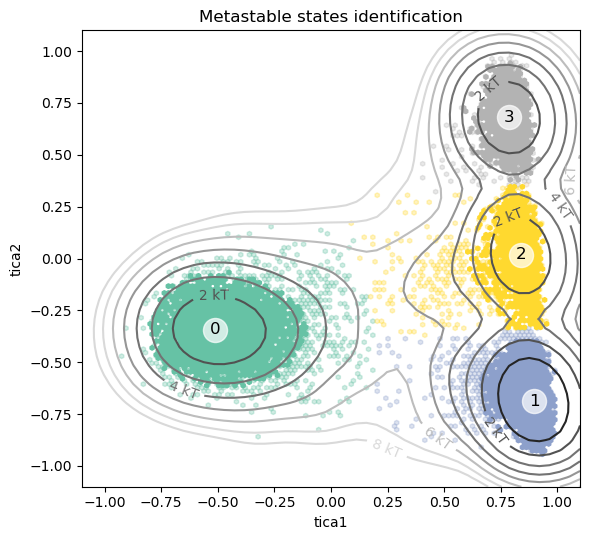

In [4]:
from stateinterpreter.plot import plot_states
plot_states(data, fes_isolines=True, save_folder = states_folder)

## Stateinterpreter

In [23]:
from stateinterpreter.classifier import MD_Data, CV_path

states_folder = 'results/chignolin-unbiased/tica-2d/'

# Load input from file
df = pd.read_csv(states_folder+'dataframe.txt', sep=' ')

# or directly from dataframe
model = MD_Data(df)

# input features
select_feat = 'HB_CONTACT' #sin_|cos_'
sample = model.sample(1000, regex_filter = select_feat)

# Define results folder (save plots and results) 
results_folder = states_folder + 'hbonds/'
!mkdir -p {results_folder}

### Linear Kernel

In [24]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter': 10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

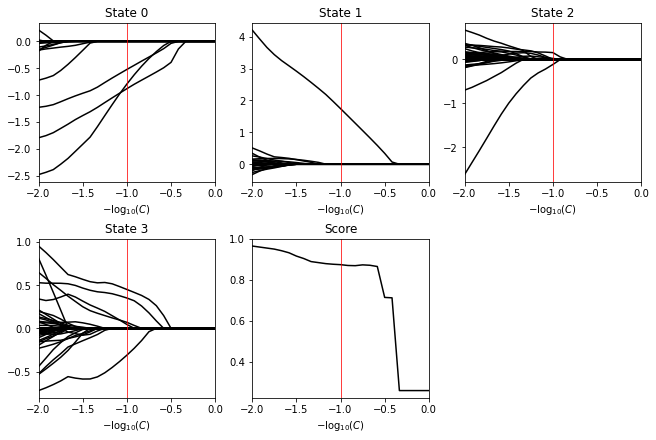

In [25]:
from stateinterpreter.plot import plot_cvpath

C = np.power(10,1)

# PLOT
base_prefix = 'linear'
plot_cvpath(cvpath,C)

if results_folder is not None:
    plt.savefig(results_folder+base_prefix+'-cvpath.png', facecolor='w', transparent=False, bbox_inches='tight')
plt.show()

In [26]:
relevant_feat = cvpath.relevant_features(C)
unique_features = cvpath.unique_features(C)

print('\n-- RELEVANT FEATURES --')
cvpath.print_relevant_features(C)

# save to file
if results_folder is not None:
    with open(results_folder+base_prefix+'-features.txt', 'w') as f:
        cvpath.print_relevant_features(C,file=f)


-- RELEVANT FEATURES --
State 0:
	 46.2% | HB_CONTACT TYR1-O -- TYR10-N
	 37.6% | HB_CONTACT ASP3-O -- GLY7-N
	 16.2% | HB_CONTACT ASP3-N -- THR8-O
State 1:
	 100.0% | HB_CONTACT THR6-OG1s -- THR8-OG1s
State 2:
	 62.6% | HB_CONTACT TYR1-O -- TYR10-N
	 36.3% | HB_CONTACT THR6-OG1s -- THR8-OG1s
	 1.1%  | HB_CONTACT ASP3-N -- GLY7-N
State 3:
	 47.2% | HB_CONTACT THR8-OG1s -- TRP9-N
	 28.7% | HB_CONTACT THR8-OG1s -- TRP9-O
	 22.5% | HB_CONTACT THR6-OG1s -- GLY7-N
	 1.1%  | HB_CONTACT TYR2-OHs -- THR8-N
	 0.5%  | HB_CONTACT ASP3-N -- TYR10-N


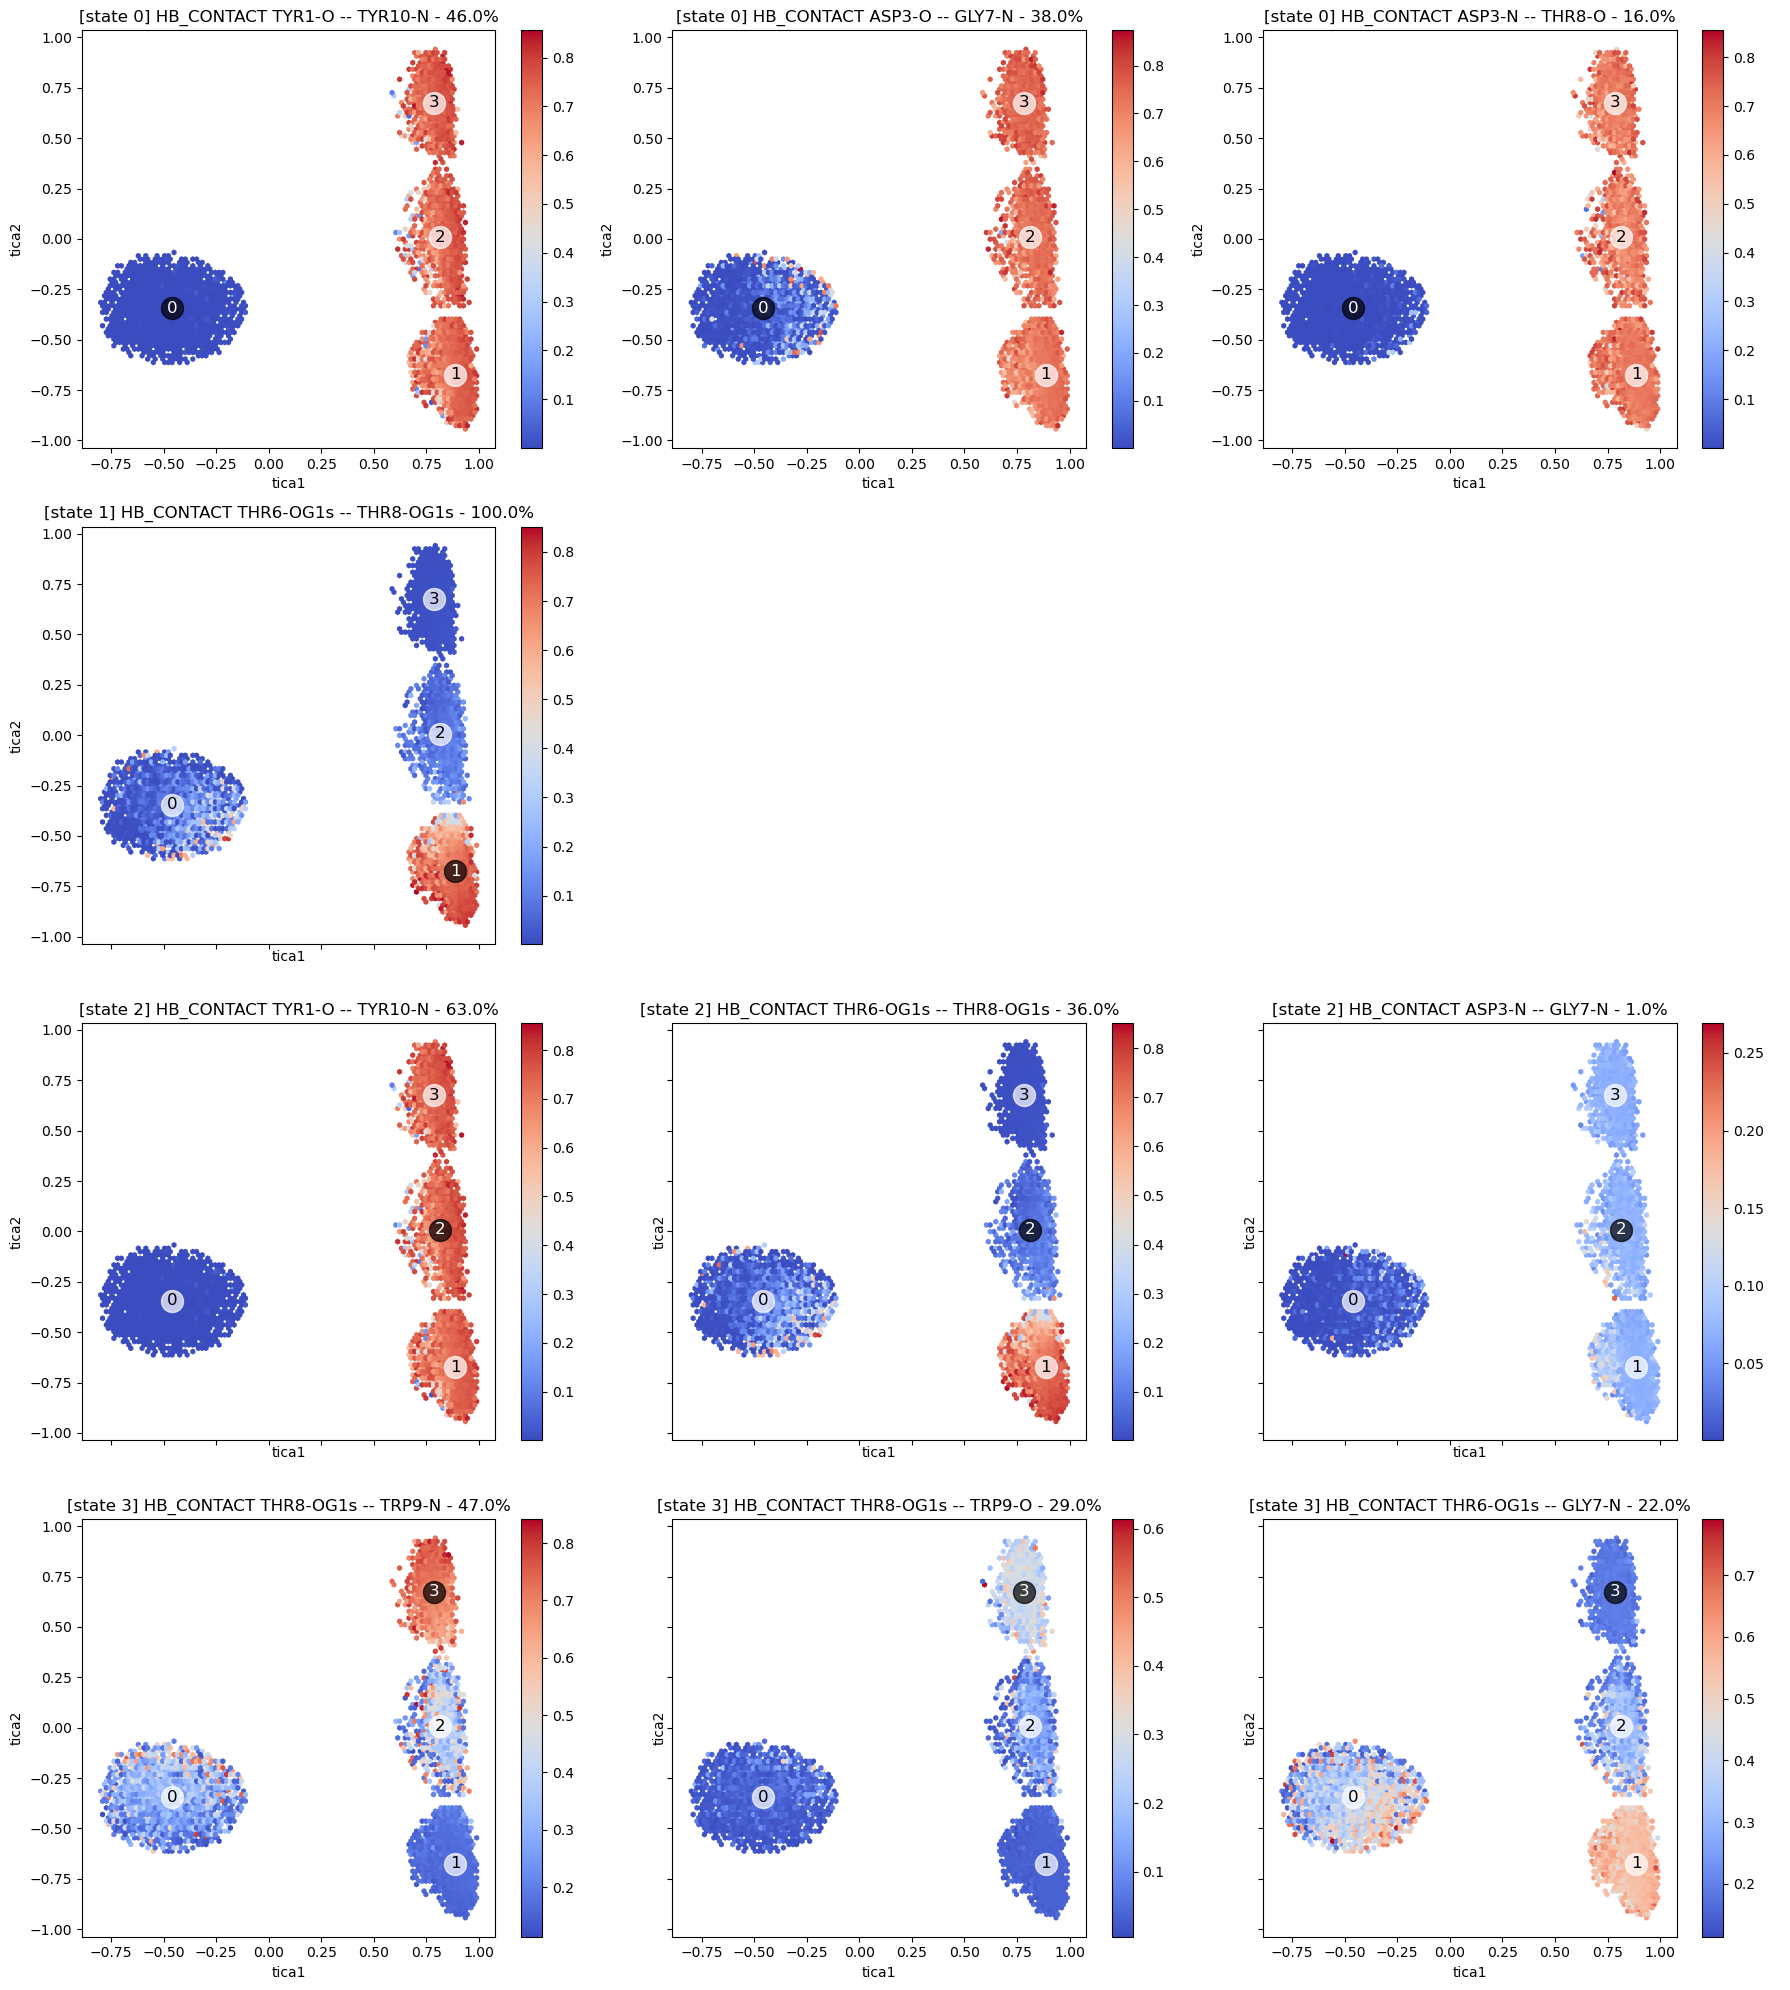

In [27]:
from stateinterpreter.plot import plot_combination_cvs_relevant_features

plot_combination_cvs_relevant_features(df,selected_cvs,relevant_feat, 
                                       save_folder=results_folder,file_prefix=base_prefix)

### Quadratic kernel

In [28]:
# Create quadratic Kernel based on features selected with C value above
prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);

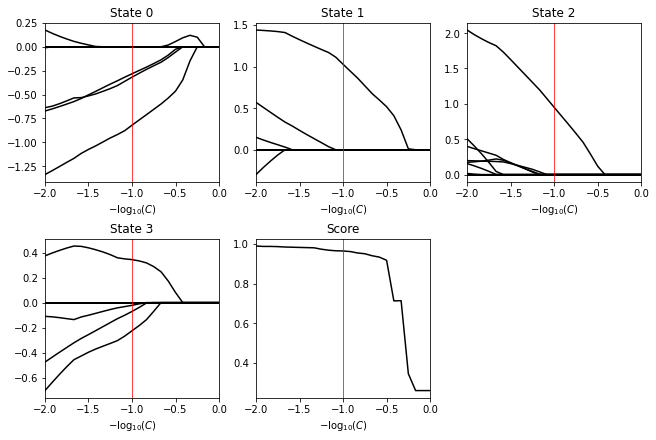

In [29]:
C = np.power(10,1)

# PLOT
base_prefix = 'pruned'
plot_cvpath(prunedcv,C)

if results_folder is not None:
    plt.savefig(results_folder+base_prefix+'-cvpath.png', facecolor='w', transparent=False, bbox_inches='tight')
plt.show()

In [30]:
relevant_feat = prunedcv.relevant_features(C)
unique_features = prunedcv.unique_features(C)

print('\n-- RELEVANT FEATURES --')
prunedcv.print_relevant_features(C)

# save to file
if results_folder is not None:
    with open(results_folder+base_prefix+'-features.txt', 'w') as f:
        prunedcv.print_relevant_features(C,file=f)

# add quadratic features to dataframe
for feat in unique_features:
    if "||" in feat:
        if feat not in df.columns: 
            i, j = feat.split(' || ')
            feat_ij = df[i].values * df[j].values
            df[feat] = feat_ij


-- RELEVANT FEATURES --
State 0:
	 78.8% | HB_CONTACT TYR1-O -- TYR10-N
	 11.8% | HB_CONTACT ASP3-N -- THR8-O
	 9.3%  | HB_CONTACT ASP3-O -- GLY7-N
State 1:
	 100.0% | HB_CONTACT THR6-OG1s -- THR8-OG1s
State 2:
	 100.0% | HB_CONTACT THR8-OG1s -- TRP9-N || HB_CONTACT THR6-OG1s -- GLY7-N
State 3:
	 67.7% | HB_CONTACT THR8-OG1s -- TRP9-N
	 29.2% | HB_CONTACT THR8-OG1s -- TRP9-N || HB_CONTACT THR6-OG1s -- GLY7-N
	 2.9%  | HB_CONTACT THR6-OG1s -- GLY7-N
	 0.3%  | HB_CONTACT THR8-OG1s -- TRP9-O || HB_CONTACT THR6-OG1s -- GLY7-N


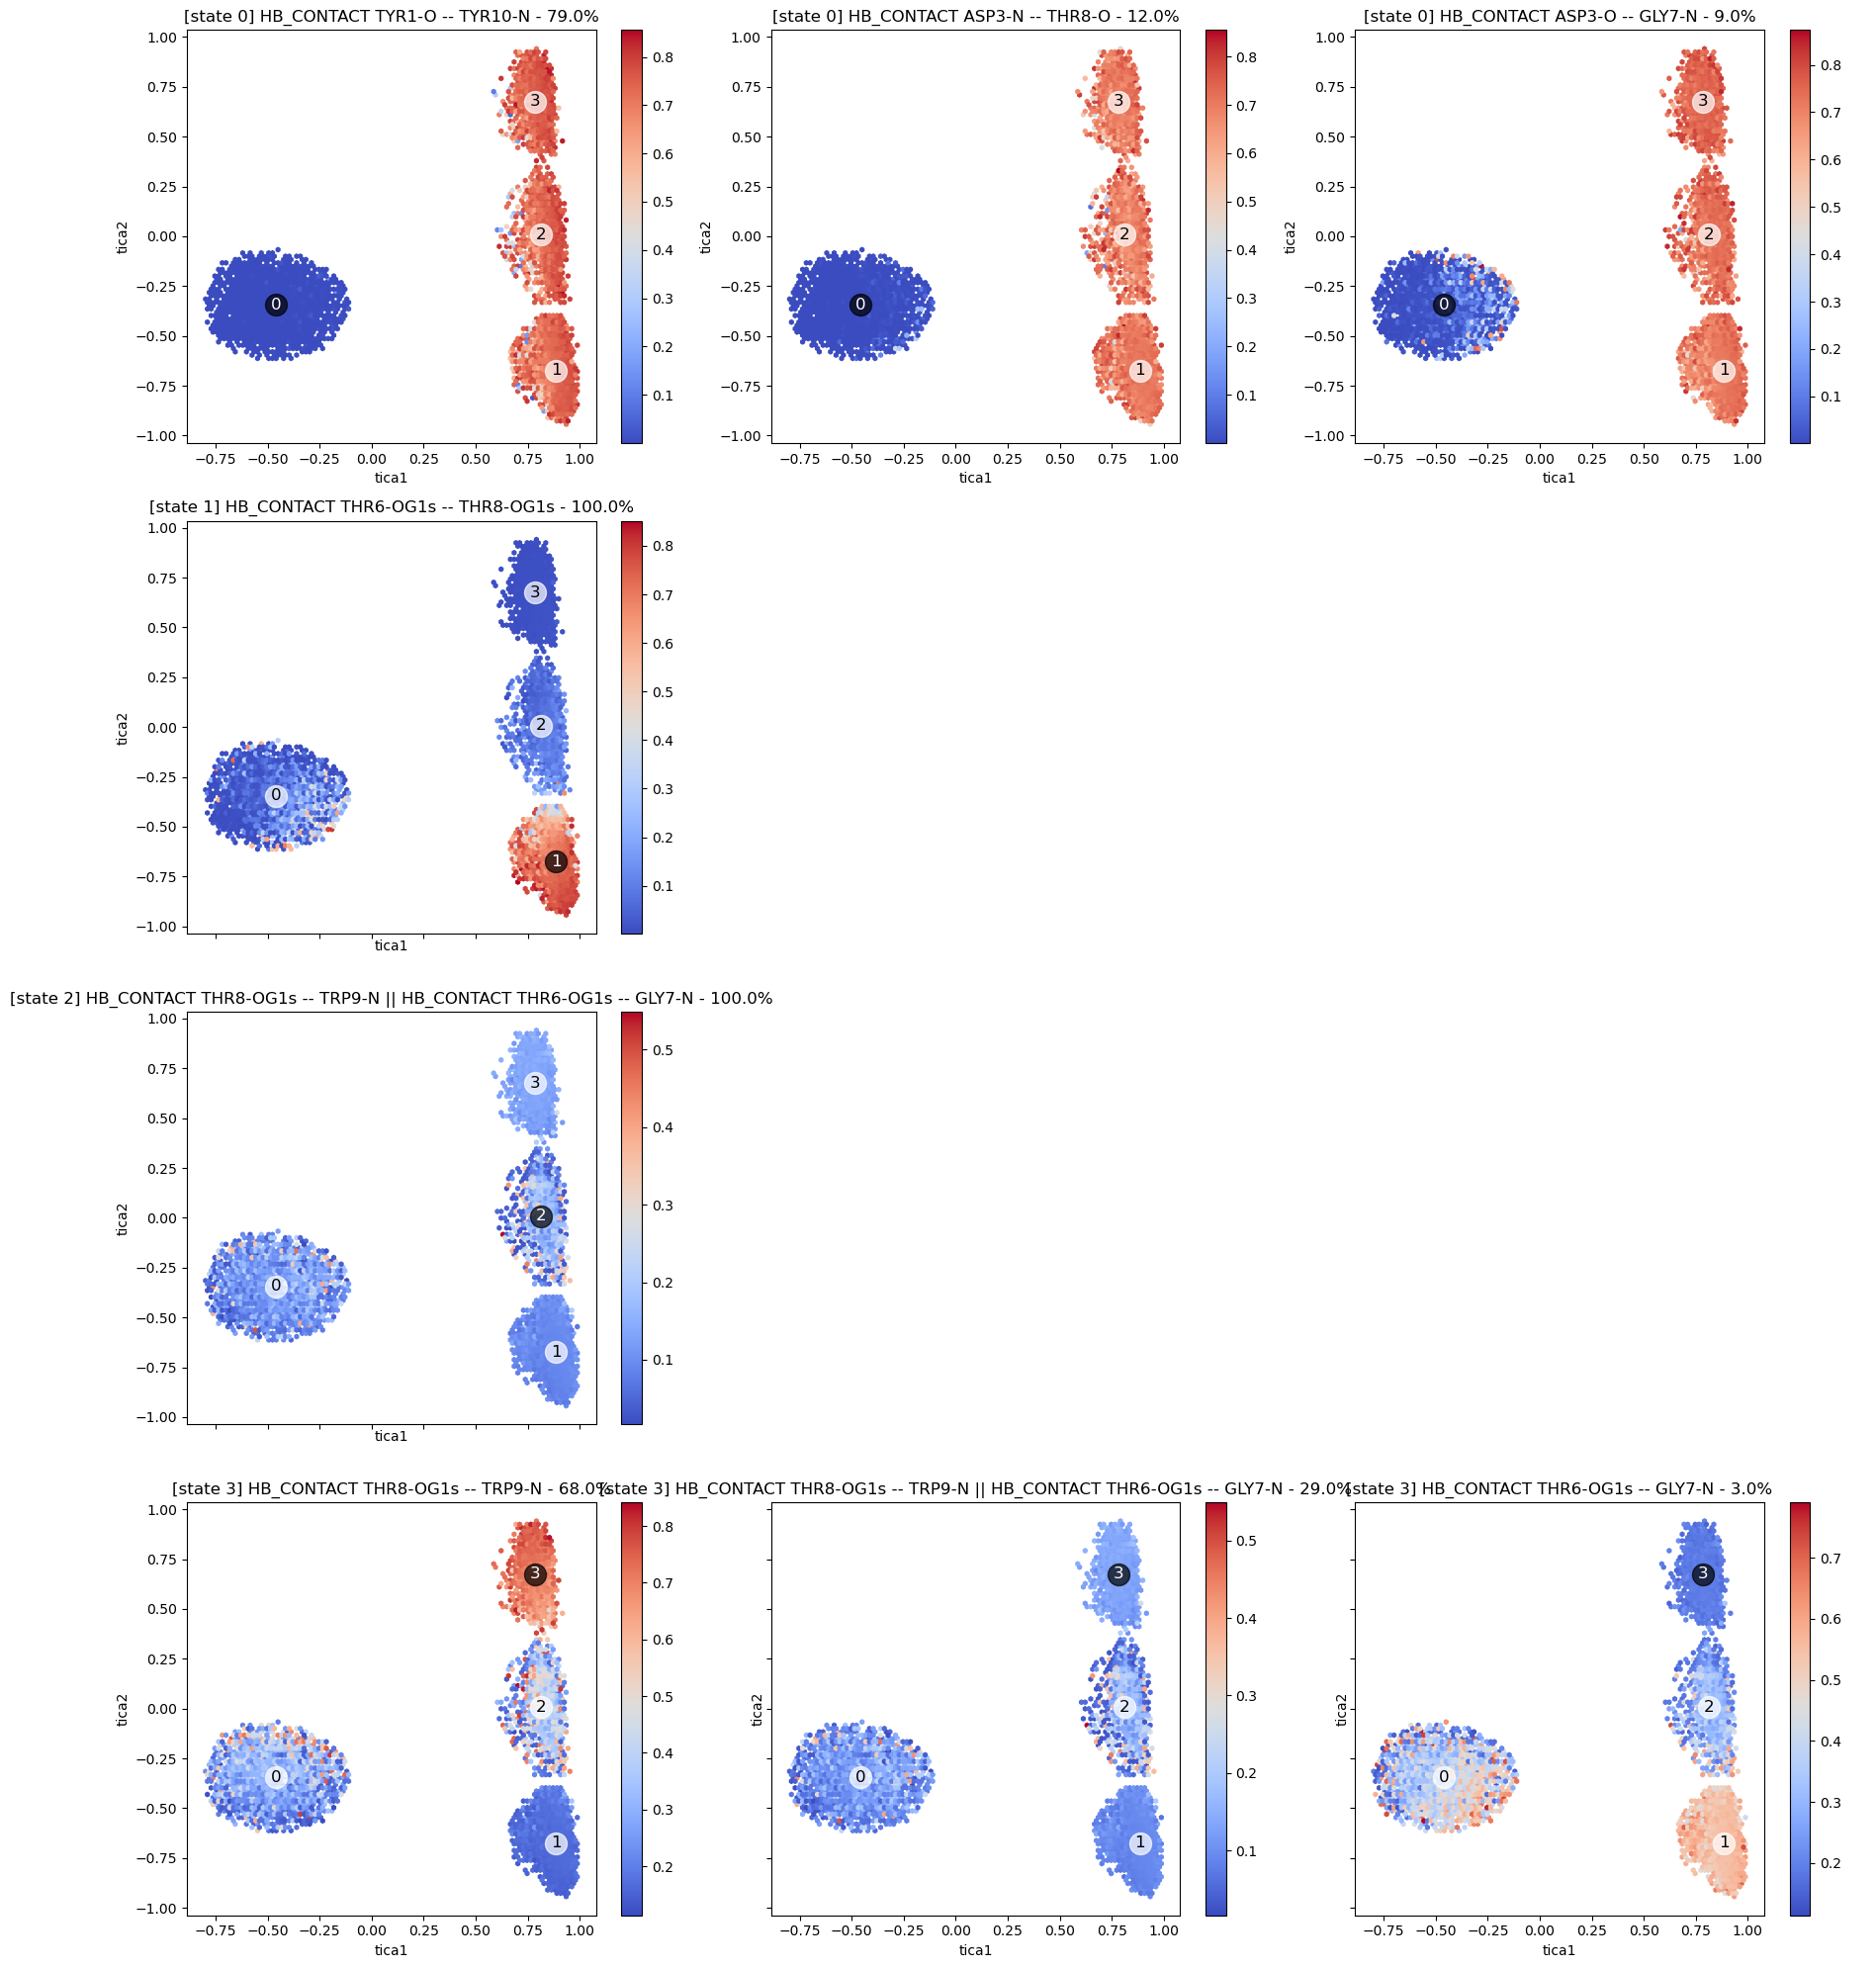

In [31]:
plot_combination_cvs_relevant_features(df,selected_cvs,relevant_feat, 
                                       save_folder=results_folder,file_prefix=base_prefix)